In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# the bare minimum
import matplotlib.pyplot as plt  # for plotting
import geopandas as gpd  # for geospatial data handling
from matplotlib.lines import Line2D

# more advanced
from lonboard._map import Map
from lonboard._layer import PolygonLayer  # for mapping in 3D
from lonboard.colormap import (
    apply_categorical_cmap,
    apply_continuous_cmap,
)  # for assigning colors
from palettable.colorbrewer.sequential import PuRd_9  # for color palettes
from matplotlib.colors import LogNorm  # for logarithmic normalization
import pygwalker as pyg  # for creating interactive data visualizations

In [38]:
gdf = gpd.read_file(
    "/Users/alinetheo/Documents/Columbia/Summer 2025/Mapping Systems/Data Sets/New York City's Flood Vulnerability Index_20250709"
)  # load geospatial data

In [39]:
gdf.head()

,geoid,fshri,ss_cur,ss_50s,ss_80s,tid_20s,tid_50s,tid_80s,geometry
0,36005008500,5,None,None,None,None,None,None,"POLYGON ((-73.90183 40.81915, -73.90167 40.819..."
1,36081008600,5,None,None,None,None,None,None,"POLYGON ((-73.84472 40.68071, -73.84307 40.680..."
2,36047058000,5,None,None,2,None,None,None,"POLYGON ((-73.95776 40.60099, -73.95683 40.601..."
3,36047053200,5,None,None,None,None,None,None,"POLYGON ((-73.9623 40.62996, -73.96137 40.6300..."
4,36081004500,5,2,5,5,None,None,None,"POLYGON ((-73.93859 40.76682, -73.93618 40.767..."


In [40]:
gdf.columns

Index(['geoid', 'fshri', 'ss_cur', 'ss_50s', 'ss_80s', 'tid_20s', 'tid_50s',
       'tid_80s', 'geometry'],
      dtype='object')

In [41]:
list(gdf.dtypes)

[dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),

In [44]:
gdf.ss_cur.value_counts()

ss_cur
5    73
2    72
4    72
1    72
3    72
Name: count, dtype: int64

In [45]:
gdf.ss_50s.value_counts()

ss_50s
5    104
3    104
1    103
2    103
4    103
Name: count, dtype: int64

In [46]:
gdf.ss_80s.value_counts()

ss_80s
5    123
3    123
2    122
1    122
4    122
Name: count, dtype: int64

In [55]:
# Define the storm surge columns and time periods
storm_surge_cols = ["ss_cur", "ss_50s", "ss_80s"]
time_periods = ["Current", "2050s", "2080s"]

# Define vulnerability categories
vulnerability_labels = {
    "1": "Very Low",
    "2": "Low",
    "3": "Moderate",
    "4": "High",
    "5": "Very High",
}

In [57]:
gdf["ss_cur_category"] = gdf.ss_cur.map(vulnerability_labels)
gdf["ss_50s_category"] = gdf.ss_50s.map(vulnerability_labels)
gdf["ss_80s_category"] = gdf.ss_80s.map(vulnerability_labels)

In [ ]:
current_summary = (
    gdf.groupby("ss_cur_category")
    .agg({"geometry": "count", "ss_cur": "mean"})
    .reset_index()
    .rename(
        columns={
            "geometry": "Number of Census Tracts",  # is this numerical?
            "ss_cur": "Average Vulnerability Score",
            "ss_cur_category": "Vulnerability Level",
        }
    )
)
# think about what we're trying to plot, reframe the question

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
twenty_fifty_summary = (
    gdf.groupby("ss_50s_category")
    .agg({"geometry": "count", "ss_50s": "mean"})
    .reset_index()
    .rename(
        columns={
            "geometry": "Number of Census Tracts",
            "ss_50s": "Average Vulnerability Score",
            "ss_cur_category": "Vulnerability Level",
        }
    )
)
twenty_fifty_summary

In [ ]:
twenty_eighty_summary = (
    gdf.groupby("ss_80s_category")
    .agg({"geometry": "count", "ss_80s": "mean"})
    .reset_index()
    .rename(
        columns={
            "geometry": "Number of Census Tracts",
            "ss_80s": "Average Vulnerability Score",
            "ss_cur_category": "Vulnerability Level",
        }
    )
)
twenty_eighty_summary

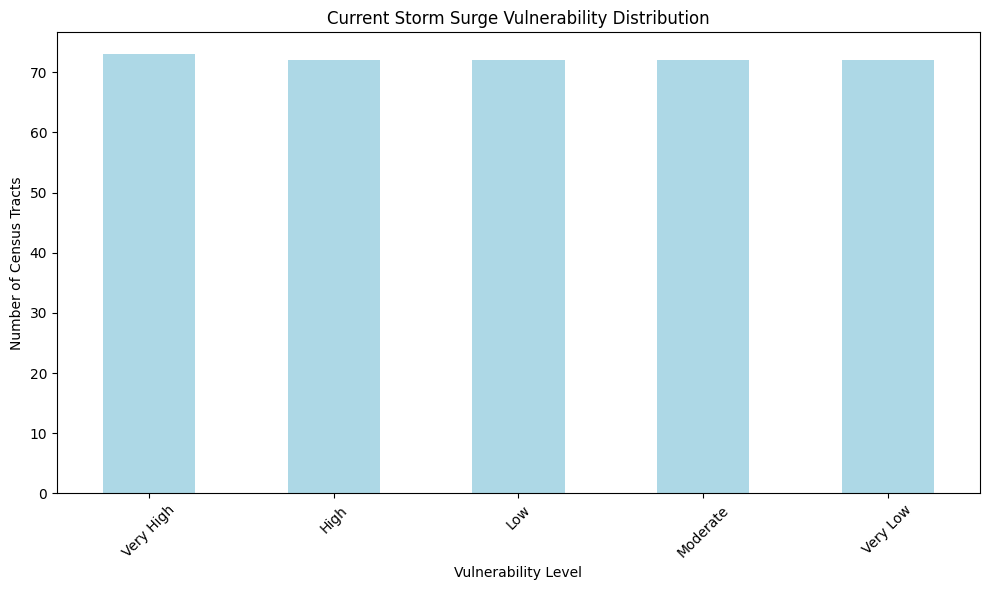

In [62]:
gdf.groupby("ss_cur_category").size().sort_values(ascending=False).plot.bar(
    color="lightblue", figsize=(10, 6)
)
plt.title("Current Storm Surge Vulnerability Distribution")
plt.ylabel("Number of Census Tracts")
plt.xlabel("Vulnerability Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

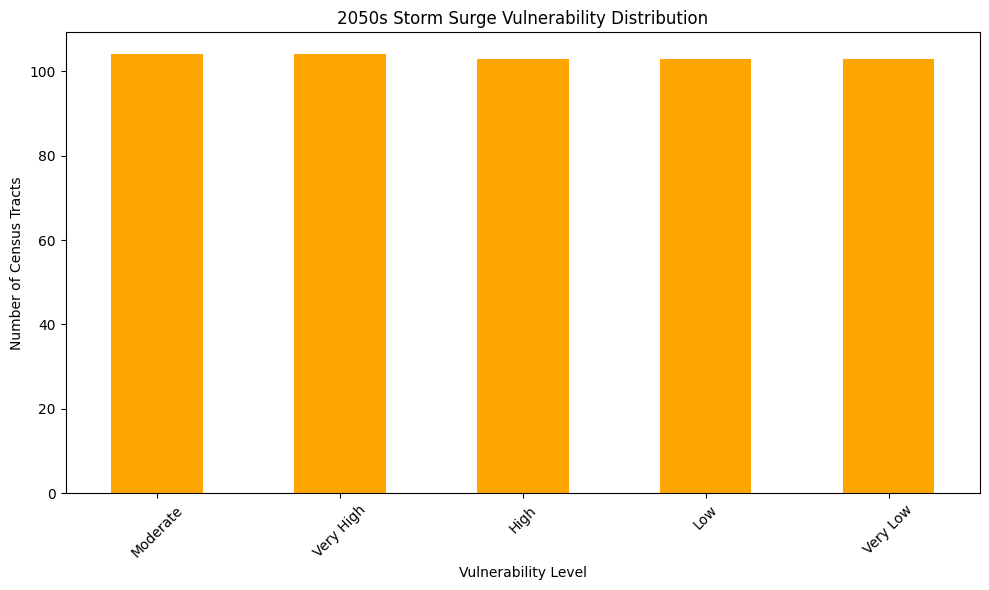

In [63]:
gdf.groupby("ss_50s_category").size().sort_values(ascending=False).plot.bar(
    color="orange", figsize=(10, 6)
)
plt.title("2050s Storm Surge Vulnerability Distribution")
plt.ylabel("Number of Census Tracts")
plt.xlabel("Vulnerability Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

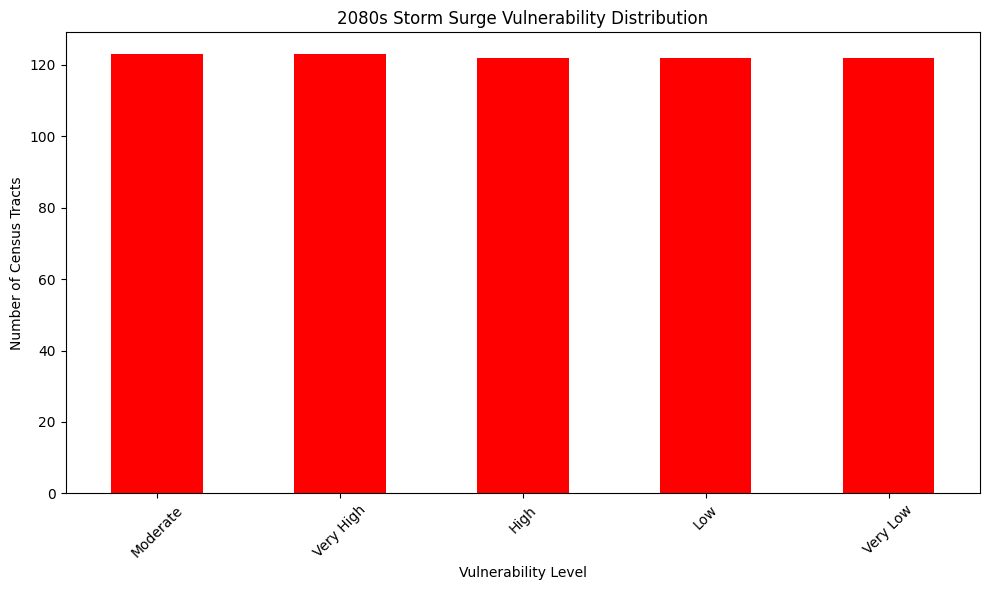

In [64]:
# Plot 2080s vulnerability distribution
gdf.groupby("ss_80s_category").size().sort_values(ascending=False).plot.bar(
    color="red", figsize=(10, 6)
)
plt.title("2080s Storm Surge Vulnerability Distribution")
plt.ylabel("Number of Census Tracts")
plt.xlabel("Vulnerability Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

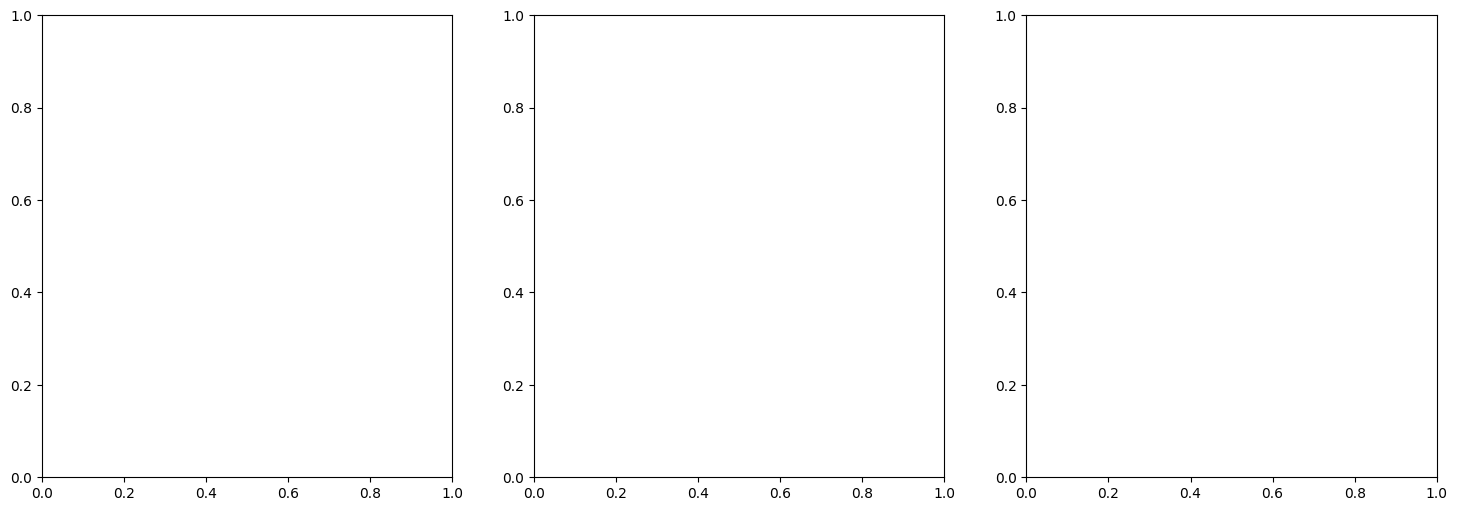

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

In [66]:
# Current
gdf.groupby("ss_cur_category").size().plot.bar(
    ax=axes[0], color="lightblue", title="Current"
)
axes[0].set_ylabel("Number of Census Tracts")
axes[0].tick_params(axis="x", rotation=45)

# 2050s
gdf.groupby("ss_50s_category").size().plot.bar(
    ax=axes[1], color="orange", title="2050s"
)
axes[1].set_ylabel("Number of Census Tracts")
axes[1].tick_params(axis="x", rotation=45)

# 2080s
gdf.groupby("ss_80s_category").size().plot.bar(ax=axes[2], color="red", title="2080s")
axes[2].set_ylabel("Number of Census Tracts")
axes[2].tick_params(axis="x", rotation=45)

plt.suptitle("Storm Surge Vulnerability Over Time", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'NYC Flood Vulnerability Index Map')

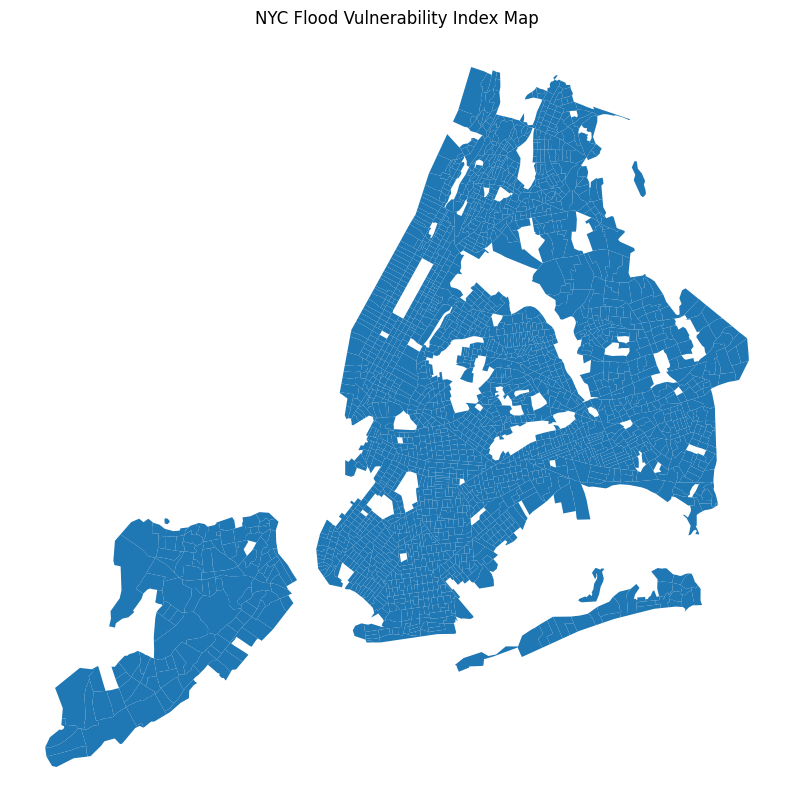

In [69]:
gdf.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC Flood Vulnerability Index Map")

In [70]:
cmap = {
    "1": "Very Low","#ff0000",
    "2": "Low", "#ff4000",
    "3": "Moderate","#001580",
    "4": "High", "#7700ff",
    "5": "Very High","#808080",
}

SyntaxError: ':' expected after dictionary key (4093948740.py, line 2)

In [ ]:
pluto.fillna({""Vulnerability Labels"": "Unknown"}, inplace=True)